In [20]:
import pandas as pd
from sklearn.metrics import accuracy_score

from common.data_frame_columns import PM10, PM2_5, PM1
from common.date_time_helper import convert_to_datetime
from common.endpoints_urls import endpoints_config
from common.working_dataset_config import working_datetime, test_date_time_strings
from data_management.data_crawler import DataManager
from data_management.data_reshaper import reshape_data, prepare_dataset, flatten_data
from data_management.labeled_data_generator import LabeledDataGenerator, DataLabel
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

In [21]:
class KNNClassifier:
    def __init__(self, neighbours, metric):
        self.knn = KNeighborsClassifier(n_neighbors=neighbours, metric=metric)

    def fit_data(self, labeled_data, columns):
        X, y = prepare_dataset(labeled_data, columns)
        X = flatten_data(X)
        self.knn.fit(X, y)

    def test_accuracy(self, labeled_data, columns):
        X_set, y_set = prepare_dataset(labeled_data, columns)
        X_set = flatten_data(X_set)
        predicted = self.knn.predict(X_set)
        accuracy = accuracy_score(y_set, predicted)
        # print("Accuracy of KNN: ", accuracy)
        # wrong_predicitons = [[DataLabel(p), DataLabel(y)] for p, y in zip(predicted, y_set) if p != y]
        # print("[Predicted, Actual]")
        # for error in wrong_predicitons:
        #     print(str(error[0]) + ", " + str(error[1]))
        return accuracy


In [22]:
date_strings = ['01.01.2021 00:00', '28.02.2024 23:59']
test_dates_string = ['01.03.2024 00:00', '30.03.2024 23:59']

training_dates = [convert_to_datetime(date_strings[0]), convert_to_datetime(date_strings[1])]
test_dates = [convert_to_datetime(test_dates_string[0]), convert_to_datetime(test_dates_string[1])]

datas = DataManager(True).get_all_endpoints_data(endpoints_config, update=True)

column = PM10
L = LabeledDataGenerator(column)

test_data = L.generate_labeled_data(datas[:1], test_dates[0], test_dates[1], 40)
single_data = L.generate_labeled_data(datas[:1], training_dates[0], training_dates[1], 40)
multi_data = L.generate_labeled_data(datas, training_dates[0], training_dates[1], 40)

Loading station data: Gronie  https://datahub.ki.agh.edu.pl/api/endpoints/70/data/
    # Minimal data: 2022-07-13 23:38:02+00:00
    # Maximal data: 2024-04-25 09:34:08+00:00
# Updating data for given endpoint... 
    # Minimal data: 2022-07-13 23:38:02+00:00
    # Maximal data: 2024-04-25 10:04:00+00:00
Loading station data: Urząd Gminy  https://datahub.ki.agh.edu.pl/api/endpoints/71/data/


/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/data_management/data_crawler.py:93: DtypeWarning: Columns (42,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


    # Minimal data: 2021-10-07 18:51:17+00:00
    # Maximal data: 2024-04-25 09:39:36+00:00
# Updating data for given endpoint... 
    # Minimal data: 2021-10-07 18:51:17+00:00
    # Maximal data: 2024-04-25 10:10:22+00:00
Loading station data: Młynne  https://datahub.ki.agh.edu.pl/api/endpoints/72/data/
    # Minimal data: 2021-10-07 19:17:59+00:00
    # Maximal data: 2024-04-25 09:48:15+00:00
# Updating data for given endpoint... 
    # Minimal data: 2021-10-07 19:17:59+00:00
    # Maximal data: 2024-04-25 10:18:16+00:00
Loading station data: Sucharskiego  https://datahub.ki.agh.edu.pl/api/endpoints/73/data/
    # Minimal data: 2021-10-07 19:41:43+00:00
    # Maximal data: 2024-04-25 09:36:38+00:00
# Updating data for given endpoint... 
    # Minimal data: 2021-10-07 19:41:43+00:00
    # Maximal data: 2024-04-25 10:06:38+00:00
Loading station data: Twardowskiego  https://datahub.ki.agh.edu.pl/api/endpoints/74/data/
    # Minimal data: 2021-10-07 20:59:56+00:00
    # Maximal data: 202

checking: knn_SDSC
   10
   20
   30
   40
   50
   60
   70
   80
   90
checking: knn_SDMC
   10
   20
   30
   40
   50
   60
   70
   80
   90
checking: knn_MDSC
   10
   20
   30
   40
   50
   60
   70
   80
   90
checking: knn_MDMC
   10
   20
   30
   40
   50
   60
   70
   80
   90


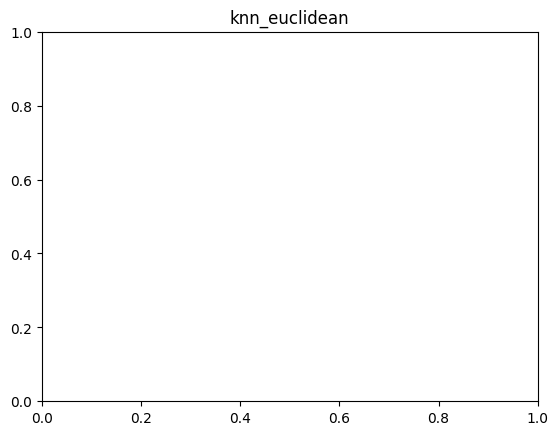

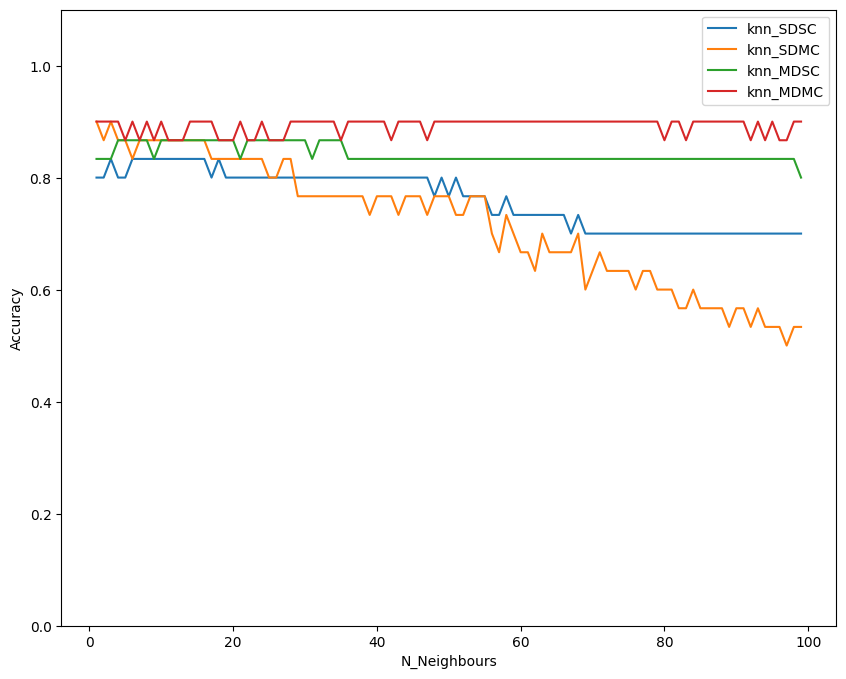

In [29]:
from matplotlib import pyplot as plt

names_of_metrics = ['euclidean', 'cityblock', 'cosine']
neighbours_max = 100
config_list = [
    {
        'name': 'knn_SDSC',
        'metrics': names_of_metrics,
        'columns': [PM10],
        'training_datas': single_data,
        'test_datas': test_data
    },
    {
        'name': 'knn_SDMC',
        'metrics': names_of_metrics,
        'columns': [PM10, PM1, PM2_5],
        'training_datas': single_data,
        'test_datas': test_data
    },
    {
        'name': 'knn_MDSC',
        'metrics': names_of_metrics,
        'columns': [PM10],
        'training_datas': multi_data,
        'test_datas': test_data
    },
    {
        'name': 'knn_MDMC',
        'metrics': names_of_metrics,
        'columns': [PM10, PM1, PM2_5],
        'training_datas': multi_data,
        'test_datas': test_data
    }
]

plt.title('knn_euclidean')
plt.figure(figsize=(10, 8))
plt.ylabel('Accuracy')
plt.xlabel('N_Neighbours')
for config in config_list:
    name = config['name']
    print("checking: " + name)
    x = []
    y = []
    for i in range(1, neighbours_max):
        if i%10==0:
            print(f'   {i}')
        knn = KNNClassifier(i, 'euclidean')
        knn.fit_data(config['training_datas'], config['columns'])
        accuracy = knn.test_accuracy(config['test_datas'], config['columns'])
        x.append(i)
        y.append(accuracy)

    plt.plot(x, y, label=name)
plt.ylim(0, 1.1)
plt.legend()
plt.show()

